In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
path = glob('../data/number-plate-detection/images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:
    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [3]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,../data/number-plate-detection/images/N107.xml,207,356,174,287
1,../data/number-plate-detection/images/N113.xml,39,108,129,157
2,../data/number-plate-detection/images/N62.xml,289,421,188,232
3,../data/number-plate-detection/images/N89.xml,150,378,217,269
4,../data/number-plate-detection/images/N88.xml,208,370,89,173


In [4]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('../data/number-plate-detection/images',filename_image)
    return filepath_image
getFilename(filename)

'../data/number-plate-detection/images/N107.jpeg'

In [5]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]

['../data/number-plate-detection/images/N107.jpeg',
 '../data/number-plate-detection/images/N113.jpeg',
 '../data/number-plate-detection/images/N62.jpeg',
 '../data/number-plate-detection/images/N89.jpeg',
 '../data/number-plate-detection/images/N88.jpeg',
 '../data/number-plate-detection/images/N63.jpeg',
 '../data/number-plate-detection/images/N77.jpeg',
 '../data/number-plate-detection/images/N112.jpeg',
 '../data/number-plate-detection/images/N106.jpeg',
 '../data/number-plate-detection/images/N110.jpeg']

In [ ]:
file_path = '../data/number-plate-detection/images/N2.jpeg' #path of our image N2.jpeg
img = cv2.imread(file_path) #read the image
# xmin-1804/ymin-1734/xmax-2493/ymax-1882
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 8 - N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=1804, x1=2493, y0=1734, y1=1882, xref='x', yref='y',line_color='cyan')

In [7]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [8]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [9]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

In [10]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

In [27]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [12]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train ,y=y_train ,batch_size=10 ,epochs=10 ,validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 904ms/step - loss: 0.0766 - val_loss: 0.0583
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 823ms/step - loss: 0.0198 - val_loss: 0.0215
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 828ms/step - loss: 0.0070 - val_loss: 0.0147
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 892ms/step - loss: 0.0044 - val_loss: 0.0143
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 852ms/step - loss: 0.0073 - val_loss: 0.0138
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 864ms/step - loss: 0.0046 - val_loss: 0.0113
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 872ms/step - loss: 0.0033 - val_loss: 0.0094
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 878ms/step - loss: 0.0029 - val_loss: 0.0101
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 875ms/step - loss: 0.0035 - val_loss: 0.0086
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 877ms/step - loss: 0.0030 - val_loss: 0.0102


In [13]:
model.save('./object_detection.keras')

In [14]:
# Load model
model = tf.keras.models.load_model('./object_detection.keras')
print('Model loaded Sucessfully')

Model loaded Sucessfully


In [15]:
path = '../data/number-plate-detection/TEST/TEST.jpeg'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)

Height of the image = 729
Width of the image = 901


In [ ]:
fig = px.imshow(image)
fig.update_layout(width=700, height=500,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure 13 - TEST Image')

In [17]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [18]:
# Make predictions
coords = model.predict(test_arr)
coords

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[0.43038425, 0.6409124 , 0.5769373 , 0.73626894]], dtype=float32)

In [19]:
# Denormalize the values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[387.77620789, 577.46208465, 420.58730471, 536.7400555 ]])

In [20]:
coords = coords.astype(np.int32)
coords

array([[387, 577, 420, 536]], dtype=int32)

In [21]:
# Draw bounding on top the image
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(np.int32(387), np.int32(420)) (np.int32(577), np.int32(536))


In [ ]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))

In [ ]:
# Create pipeline
path = '../data/fifty-states-car-license-plates-dataset/Fifty States License Plates/California.jpg'
def object_detection(path):

    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))

    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)

    # Make predictions
    coords = model.predict(test_arr)

    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)

    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

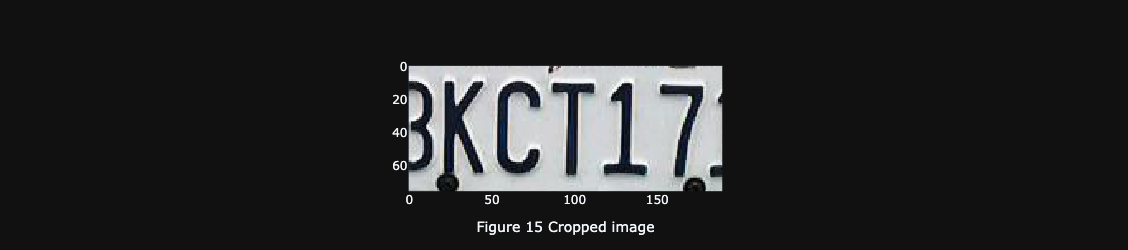

In [24]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]+10
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 15 Cropped image')

In [25]:
# extract text from image
text = pt.image_to_string(roi)
print(text)

TesseractError: (1, 'Error opening data file /opt/anaconda3/envs/ibd-project-11/share/tessdata Please make sure the TESSDATA_PREFIX environment variable is set to your "tessdata" directory. Failed loading language \'eng\' Tesseract couldn\'t load any languages! Could not initialize tesseract.')